Self-Supervised Learning

1. Generative Learning 
2. Proxy Task Learning 
3. Contrative Learning * 주된 방법론 

In [ ]:
## 출처 : https://jimmy-ai.tistory.com/312

In [ ]:
## Contrative Learning 
'''
Contrative Loss를 사용하는데 중요한 전제가 있다.
Promise: Augmentation은 Segmentation한 정보를 바꾸지 않는다.


같은 이미지에서 Augmentation된 이미지 집단을 Positive Sample
다른 이미지에서 Augmentation된 이미지 집단을 Negative Sample
'''

In [1]:
## Data 불러오기

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

c:\Users\s\anaconda3\envs\pytorch_test\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
## Data split (60000 : 10000)
import torch
import numpy as np


device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
train_x =torch.Tensor(np.array(mnist['data'])).float().reshape(-1,1,28,28)[:60000]
train_y = torch.Tensor(np.array(list(map(np.int_, mnist.target))))[:60000]

test_x = torch.tensor(np.array(mnist.data)).float().reshape(-1, 1, 28, 28)[60000:]
test_y = torch.Tensor(np.array(list(map(np.int_, mnist.target))))[60000:]

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [5]:
def cutout_and_rotate(image):
    image = image.clone().detach() # 얕은 복사 문제 주의(원본 유지)
    x_start = np.random.randint(20) # cut out 시작할 x축 위치(0~19 중 1개)
    y_start = np.random.randint(20) # cut out 시작할 y축 위치(0~19 중 1개)

    image[..., x_start:x_start+9, y_start:y_start+9] = 255 / 2 # 해당 부분 회색 마킹
    return torch.rot90(image, 1, [-2, -1]) # 마지막 두 axis 기준 90도 회전

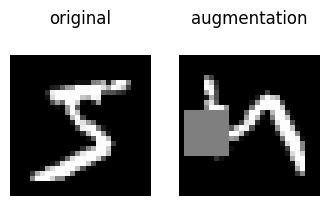

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import style

# 흰색 배경 및 크기 지정
style.use('default')
figure = plt.figure()
figure.set_size_inches(4, 2)

# 흑백으로 출력하기 위한 스타일 설정
style.use('grayscale')

# 1 * 2 사이즈의 격자 설정
axes = []
for i in range(1, 3):
    axes.append(figure.add_subplot(1, 2, i))

# 첫 이미지에 대한 원본 이미지 및 augmentation 수행된 이미지 시각화
img_example = train_x[0].clone().detach().cpu()
original = np.array(img_example).reshape(-1, 28).astype(int)
aug_img = np.array(cutout_and_rotate(img_example)).reshape(-1, 28).astype(int)

axes[0].matshow(original)
axes[1].matshow(aug_img)

# 제목 설정 및 눈금 제거
axes[0].set_axis_off()
axes[0].set_title('original')
axes[1].set_axis_off() 
axes[1].set_title('augmentation')

plt.show()

In [6]:
mask = torch.ones((5, 5), dtype=bool)
mask = mask.fill_diagonal_(0) # 대각선의 값은 0으로 대체 한다는 의미
print(mask)
print(mask.diag())

tensor([[False,  True,  True,  True,  True],
        [ True, False,  True,  True,  True],
        [ True,  True, False,  True,  True],
        [ True,  True,  True, False,  True],
        [ True,  True,  True,  True, False]])
tensor([False, False, False, False, False])


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1)
        self.fc = nn.Linear(4 * 4 * 20, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x)) # (batch, 1, 28, 28) -> (batch, 10, 24, 24)

        x = F.max_pool2d(x, kernel_size=2, stride=2) # (batch, 10, 24, 24) -> (batch, 10, 12, 12)

        x = F.relu(self.conv2(x)) # (batch, 10, 12, 12) -> (batch, 20, 8, 8)

        x = F.max_pool2d(x, kernel_size=2, stride=2) # (batch, 20, 8, 8) -> (batch, 20, 4, 4)

        x = x.view(-1, 4 * 4 * 20) # (batch, 20, 4, 4) -> (batch, 320)

        x = F.relu(self.fc(x)) # (batch, 320) -> (batch, 100)
        return x # (batch, 100)

In [9]:
## batch size == 3
N = 3 * 2
mask = torch.ones((N,N), dtype=bool)
mask = mask.fill_diagonal_(0)

for i in range(3):
    mask[i,3 + i] = 0
    mask[3 + i, i] = 0
print(mask)

tensor([[False,  True,  True, False,  True,  True],
        [ True, False,  True,  True, False,  True],
        [ True,  True, False,  True,  True, False],
        [False,  True,  True, False,  True,  True],
        [ True, False,  True,  True, False,  True],
        [ True,  True, False,  True,  True, False]])


In [13]:
## 코드를 이해하기 위한 코드들 
z_i = [[1,2,3,4,5],[-1,-2,-3,-4,-5]]
z_j = [[6,7,8,9,10],[-6,-7,-8,-9,-10]]
z_i = torch.Tensor(z_i)
z_j = torch.Tensor(z_j)

import torch.nn as nn

emb = torch.cat([z_i,z_j], dim = 0)
print(emb)
print('='*10)

print(emb.unsqueeze(0), emb.unsqueeze(0).shape) # unsqueeze는 차원을 생성해주는 함수 dim=0인 차원을 생성
print(emb.unsqueeze(1), emb.unsqueeze(1).shape) # dim =1 인 차원을 생성해주는 것 


print('='*10)
similarity_f = nn.CosineSimilarity(dim=2)
sim = similarity_f(emb.unsqueeze(0), emb.unsqueeze(1)) 
print(sim)

sim_i_j = torch.diag(sim, 2)
sim_j_i = torch.diag(sim, -2)

print('=' * 10)
print(sim_i_j)
print(sim_j_i)

tensor([[  1.,   2.,   3.,   4.,   5.],
        [ -1.,  -2.,  -3.,  -4.,  -5.],
        [  6.,   7.,   8.,   9.,  10.],
        [ -6.,  -7.,  -8.,  -9., -10.]])
tensor([[[  1.,   2.,   3.,   4.,   5.],
         [ -1.,  -2.,  -3.,  -4.,  -5.],
         [  6.,   7.,   8.,   9.,  10.],
         [ -6.,  -7.,  -8.,  -9., -10.]]]) torch.Size([1, 4, 5])
tensor([[[  1.,   2.,   3.,   4.,   5.]],

        [[ -1.,  -2.,  -3.,  -4.,  -5.]],

        [[  6.,   7.,   8.,   9.,  10.]],

        [[ -6.,  -7.,  -8.,  -9., -10.]]]) torch.Size([4, 1, 5])
tensor([[ 1.0000, -1.0000,  0.9650, -0.9650],
        [-1.0000,  1.0000, -0.9650,  0.9650],
        [ 0.9650, -0.9650,  1.0000, -1.0000],
        [-0.9650,  0.9650, -1.0000,  1.0000]])
tensor([0.9650, 0.9650])
tensor([0.9650, 0.9650])


In [8]:
# SimCLR (contrative learning)
# 출처 : https://medium.com/the-owl/simclr-in-pytorch-5f290cb11dd7
import torch.nn as nn

class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    # loss 분모 부분의 negative sample 간의 내적 합만을 가져오기 위한 마스킹 행렬
    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size # batch size를 왜 곱하기 2 해주는 걸까?
        mask = torch.ones((N, N), dtype=bool) # batch size의 두배를 만들어 mask를 만들어줌
        mask = mask.fill_diagonal_(0) # 대각선의 값을 0으로 변환 (mask를 만들어 주고 대각선은 0으로 만들어줌)
        
        ## mask를 왜 이렇게 만들었을까?.. 
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        # 2개의 이미지 embedding이 concat이 되니 *2를 해준 것이다 !
        N = 2 * self.batch_size 

        z = torch.cat((z_i, z_j), dim=0) # concatenate (Tensor의 리스트를 묶어 주는 함수임) (행으로 합쳐줌) 열로 합치는 것은 dim=1
        ## Original vetor랑 Augmentation vector를 concat해줌

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        ## Cosine 유사도를 계산하기 위해서 unsqueeze로 해줌 -> temperature를 나눠주는 이유는 뭘까? 

        # loss 분자 부분의 원본 - augmentation 이미지 간의 내적 합을 가져오기 위한 부분
        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

In [108]:
(next(iter(dataloader))[0]).shape

torch.Size([32, 1, 28, 28])

In [120]:
print(next(iter(dataloader))[0].shape)
print(next(iter(dataloader))[1].shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])


In [97]:
## Training 
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

X_train_aug = cutout_and_rotate(train_x) # 각 X_train 데이터에 대하여 augmentation
X_train_aug = X_train_aug.to(device) # 학습을 위하여 GPU에 선언

dataset = TensorDataset(train_x, X_train_aug) # augmentation된 데이터와 pair
batch_size = 32

dataloader = DataLoader(
            dataset,
            batch_size = batch_size)

model = CNN() # 모델 변수 선언
loss_func = SimCLR_Loss(batch_size, temperature = 0.5) # loss 함수 선언

# train 코드 예시
epochs = 10
model.to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for i in range(1, epochs + 1):
    total_loss = 0
    for data in tqdm(dataloader):
        origin_vec = model(data[0])
        aug_vec = model(data[1])

        loss = loss_func(origin_vec, aug_vec)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch : %d, Avg Loss : %.4f'%(i, total_loss / len(dataloader)))

In [ ]:
# downstream classification

class CNN_classifier(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.CNN = model # contrastive learning으로 학습해둔 모델을 불러오기
        self.mlp = nn.Linear(100, 10) # class 차원 개수로 projection

    def forward(self, x):
        x = self.CNN(x) # (batch, 100)으로 변환
        x = self.mlp(x) # (batch, 10)으로 변환
        return x # (batch, 10)

In [ ]:
class_dataset = TensorDataset(X_train, y_train) # 데이터와 라벨 간의 pair
batch_size = 32

class_dataloader = DataLoader(
            class_dataset,
            batch_size = batch_size)

In [ ]:
class CNN_classifier(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.CNN = model # contrastive learning으로 학습해둔 모델을 불러오기
        self.mlp = nn.Linear(100, 10) # class 차원 개수로 projection

    def forward(self, x):
        x = self.CNN(x) # (batch, 100)으로 변환
        x = self.mlp(x) # (batch, 10)으로 변환
        return x # (batch, 10)

In [ ]:
classifier = CNN_classifier(model).to(device) # 모델 선언, GPU 활용 지정

classifier_loss = nn.CrossEntropyLoss() # 분류를 위한 loss 함수

epochs = 10
classifier.train()

optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)

for i in range(1, epochs + 1):
    correct = 0
    for data in tqdm(class_dataloader):
        logits = classifier(data[0])

        loss = classifier_loss(logits, data[1].long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += torch.sum(torch.argmax(logits, 1) == data[1]).item() # 정확도 산출을 위하여 정답 개수 누적

    print('Epoch : %d, Train Accuracy : %.2f%%'%(i, correct * 100 / len(train_x)))

NameError: name 'model' is not defined

In [ ]:
test_dataset = TensorDataset(test_x, test_y) # 테스트 데이터와 라벨 pair
batch_size = 32

test_dataloader = DataLoader(
            test_dataset,
            batch_size = batch_size)

classifier.eval() # 테스트 모드로 전환

correct = 0
for data in tqdm(test_dataloader):

    logits = classifier(data[0])
    correct += torch.sum(torch.argmax(logits, 1) == data[1]).item() # 정확도 산출을 위하여 정답 개수 누적

print('Test Accuracy : %.2f%%'%(correct * 100 / len(test_x)))